In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
data = pd.read_csv('C:\\Users\\Hari\\Desktop\\air-quality-predictor\\AirQualityData\\combined_dataset.csv')

# Display the first few rows to ensure it's loaded correctly
print("Initial Data:")
print(data.head())

# Drop NaN values for PM2.5
data = data.dropna(subset=['PM2.5'])

# Check for any remaining NaNs
print("\nData after dropping NaNs:")
print(data.isna().sum())

# Scale the PM2.5 values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['PM2.5']].values.reshape(-1, 1))

# Display scaled data
print("\nScaled Data Sample:")
print(scaled_data[:5])



Initial Data:
   No  year  month  day  hour  PM2.5    PM10    SO2    NO2   CO      O3  TEMP  \
0   1  2017     11   24    17  60.50   98.00  11.85  30.80  0.1  126.40  17.1   
1   2  2017     11   24    18  65.50  111.25  13.17  24.20  0.1  117.12  17.1   
2   3  2017     11   24    19  80.00  132.00  12.08  25.18  0.1   98.98  17.1   
3   4  2017     11   24    20  81.50  133.25  10.47  16.25  0.1  112.20  17.1   
4   5  2017     11   24    21  75.25  116.00   9.12  17.48  0.1  106.35  17.1   

          PRES       DEWP  RAIN          wd       WSPM  station  
0  1018.416945  12.321096   0.0   70.603359  14.810371      5.0  
1  1030.063256  13.927346   0.0  112.172908   4.649929      5.0  
2  1022.193436  11.507530   0.0  349.283080   9.156327      5.0  
3  1018.141823   8.728048   0.0  189.183347   1.011632      5.0  
4  1009.655836   7.770452   0.0  291.799889  11.017287      5.0  

Data after dropping NaNs:
No               0
year             0
month            0
day              0


In [4]:
import numpy as np

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10  # Adjust based on your needs
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], look_back, 1))

# Display shapes
print("\nShapes of created datasets:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Shapes of created datasets:
X shape: (1941384, 10, 1)
y shape: (1941384,)


In [5]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Display shapes
print("\nShapes of train and test sets:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Shapes of train and test sets:
X_train shape: (1553107, 10, 1)
X_test shape: (388277, 10, 1)
y_train shape: (1553107,)
y_test shape: (388277,)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train with fewer epochs and more verbose output
history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# Display training history
print("\nTraining History:")
print(history.history)

Epoch 1/5


c:\Users\Hari\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48535/48535 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 0.0012
Epoch 2/5
48535/48535 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - loss: 9.6599e-04
Epoch 3/5
48535/48535 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 9.3911e-04
Epoch 4/5
48535/48535 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - loss: 9.5134e-04
Epoch 5/5
48535/48535 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - loss: 9.2275e-04

Training History:
{'loss': [0.001023983466438949, 0.0009560126345604658, 0.0009401746210642159, 0.0009298065560869873, 0.0009214272140525281]}


48535/48535 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step
12134/12134 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


C:\Users\Hari\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


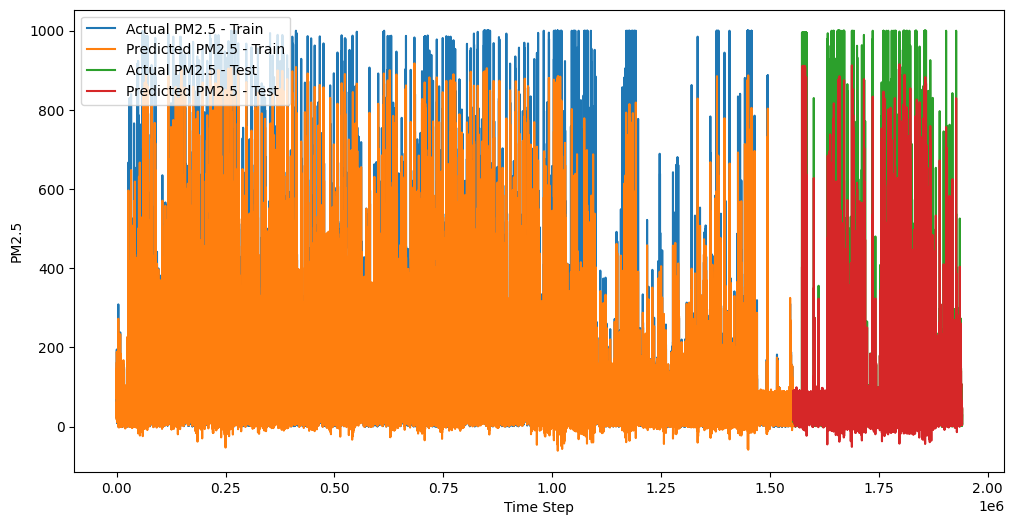

In [7]:
import matplotlib.pyplot as plt

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Actual PM2.5 - Train')
plt.plot(np.arange(len(train_predictions)), train_predictions, label='Predicted PM2.5 - Train')
plt.plot(np.arange(len(y_test_inv)) + len(y_train_inv), y_test_inv, label='Actual PM2.5 - Test')
plt.plot(np.arange(len(test_predictions)) + len(y_train_inv), test_predictions, label='Predicted PM2.5 - Test')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.show()